<h3>Training the OCR Model

In [1]:
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import tensorflow as tf
import datetime


2023-12-23 19:43:38.645291: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-23 19:43:38.648045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 19:43:38.693560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 19:43:38.694362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 19:43:39.504416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    'val',
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical'
)


Found 864 images belonging to 36 classes.


Found 216 images belonging to 36 classes.


In [3]:
# Model
model = Sequential()
model.add(Conv2D(36, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


2023-12-23 19:43:44.722062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 19:43:44.722521: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Callbacks
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.99:
            self.model.stop_training = True

In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)  # Adjust histogram_freq as needed

batch_size = 1
callbacks = [tensorboard_callback, StopTrainingCallback()]

In [7]:
# Model training
model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)


Epoch 1/20
864/864 [==============================] - 9s 9ms/step - loss: 2.2263 - accuracy: 0.3958 - val_loss: 0.9545 - val_accuracy: 0.6944
Epoch 2/20
864/864 [==============================] - 8s 9ms/step - loss: 0.5964 - accuracy: 0.8125 - val_loss: 0.4653 - val_accuracy: 0.8611
Epoch 3/20
864/864 [==============================] - 7s 8ms/step - loss: 0.3576 - accuracy: 0.8958 - val_loss: 0.3350 - val_accuracy: 0.8750
Epoch 4/20
864/864 [==============================] - 8s 9ms/step - loss: 0.2563 - accuracy: 0.9132 - val_loss: 0.2471 - val_accuracy: 0.9120
Epoch 5/20
864/864 [==============================] - 8s 9ms/step - loss: 0.1888 - accuracy: 0.9271 - val_loss: 0.1339 - val_accuracy: 0.9676
Epoch 6/20
864/864 [==============================] - 8s 9ms/step - loss: 0.1593 - accuracy: 0.9398 - val_loss: 0.1177 - val_accuracy: 0.9537
Epoch 7/20
864/864 [==============================] - 8s 9ms/step - loss: 0.1798 - accuracy: 0.9410 - val_loss: 0.2075 - val_accuracy: 0.9398
Epoch 

<h3>Extracting characters from number plate using OpenCV and Haar Cascade pre-trained to Indian number plates

In [68]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
	plate_img = img.copy()
	
	#Loads the data required for detecting the license plates from cascade classifier.
	plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

	# detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
	plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

	for (x,y,w,h) in plate_rect:
		a,b = (int(0.02*img.shape[0]), int(0.01*img.shape[1])) #parameter tuning
		#a,b = (0,0)
		plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
		# finally representing the detected contours by drawing rectangles around the edges.
		cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
	return plate_img, plate # returning the processed image
	
	

In [69]:
import matplotlib.pyplot as plt
def disp_img(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [70]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [71]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img = cv2.resize(image, (333, 75))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_erode = cv2.erode(img_binary, (3,3))
    img_dilate = cv2.dilate(img_erode, (3,3))

    LP_WIDTH = img_dilate.shape[0]
    LP_HEIGHT = img_dilate.shape[1]

    # Make borders white
    img_dilate[0:3,:] = 255
    img_dilate[:,0:3] = 255
    img_dilate[72:75,:] = 255
    img_dilate[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_dilate)

    return char_list

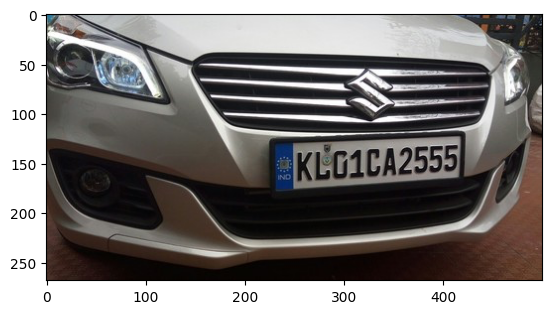

In [78]:
img = cv2.imread('Cars0.png')
disp_img(img)

In [79]:
plate_image, plate = extract_plate(img)

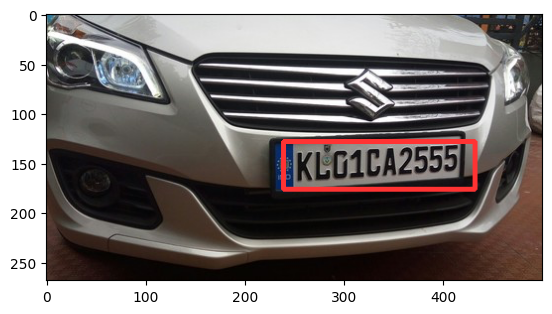

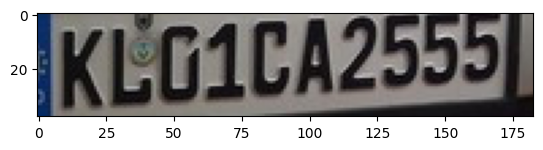

In [80]:
disp_img(plate_image)
disp_img(plate)

In [81]:
char_list = segment_characters(plate)

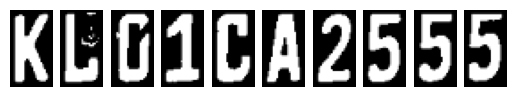

In [82]:
for i in range(len(char_list)):
    plt.subplot(1, len(char_list), i+1)
    plt.imshow(char_list[i], cmap='gray')
    plt.axis('off')

In [83]:
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 1))
    new_img[:, :, 0] = img
    return new_img

  
def show_results(char_list, model):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char_list):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 1)  # change to a single channel
        y_probs = model.predict(img)[0]  # predicting the probabilities for each class
        y_ = np.argmax(y_probs)  # extracting the class with the highest probability
        character = dic[y_]
        output.append(character)  # storing the result in a list

    plate_number = ''.join(output)

    return plate_number

print(show_results(char_list, model))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step
KEG1CA2555


1/1 [==============================] - 0s 20ms/step


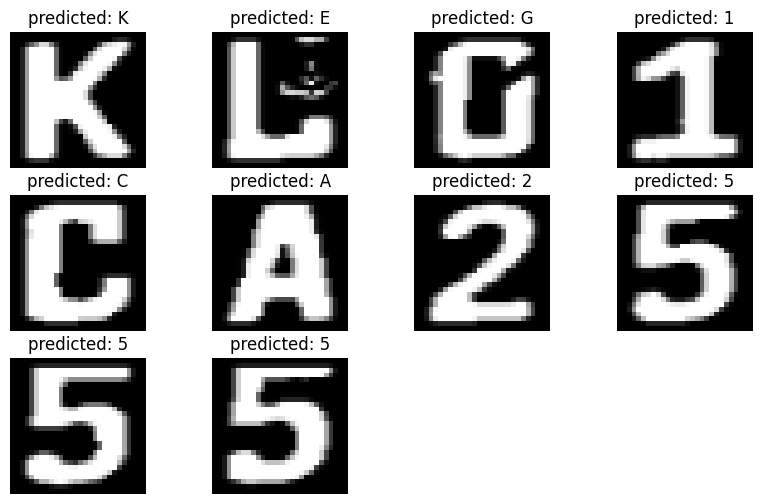

In [84]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char_list):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(char_list,model)[i]}')
    plt.axis('off')
plt.show()
